# Bike Counts Montreal 2019-2023

Exploration of the number of passages collected by the City of Montreal's (Quebec, Canada) 44 bike counters, located throughout the City's bike pathes, between 2019 to (January of) 2023. The datset is freely available in the [City of Montreal's OpenData website](https://donnees.montreal.ca/ville-de-montreal/velos-comptage).

- Data is available from 2017 to 2023 (January, as of the date of analysis)
- Datasets from 2017 and 2018 seem too messy
- Only use data from 44 counters (out of 63 in total) that have data for every year between January 2019 and January 2023, inclusively
- Missing data for the entire month of July 2021 is removed
- July 2019 has a large standard deviation due to a high-value outlier caused by "compteur_39". Leave the datapoint in the dataset and rely on medians
- There is a downward trend of counts from 2020. The same trend goes upwards when we use the complete dataset from all counters.
- 2020 is the first year of the pandemic
- There have been several more bike counters added since 2017 (63 as of January 2023)
- No major changes in public policies (under Valerie Plante for the City of Montreal, and François Legault for the Province of Quebec)

## TODO

- Add climate data (e.g., temperature, precipitation) http://ville.montreal.qc.ca/portal/page?_pageid=6897,67875636&_dad=portal&_schema=PORTAL)
- Pandemic effect?


In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

os.listdir()

['.git',
 'LICENSE',
 'README.md',
 'data',
 'fig-barplot_bikes_per_month_2019-2023.png',
 'fig-barplot_bikes_per_year_2019-2023.png',
 'fig-boxplot_bikes_by_seasons_2019-2023.png',
 'fig-boxplot_bikes_per_month_2019-2023.png',
 'velo-counter.ipynb',
 'velo_counts_mtl_2019-2023.ipynb']

## Explore the dataset

Load and inspect dataset downloaded from the [City of Montreal's Open Data Portal for bikepath counters](https://donnees.montreal.ca/ville-de-montreal/velos-comptage).

- 2023: Only for January. Table in "long" format, whereas in "wide" format for previous years.
- 2017 and 2018: Counters have actual location names, and data is summarised by day
- 2019-2022: Counters use identifiers "compteur_#####". Table in wide format. Consistent
- 2019: "compteur_39" for July 2019 looks like an outlier
- 2021: Missing the month of July

In [30]:
# Import datasets and inspect their structure
# df_counters holds a list of all available bike counters

df_counters = pd.read_csv("data/localisation_des_compteurs_velo.csv")
df_2017     = pd.read_csv("data/comptagevelo2017.csv")
df_2018     = pd.read_csv("data/comptage_velo_2018.csv")
df_2019     = pd.read_csv("data/comptage_velo_2019.csv")
df_2020     = pd.read_csv("data/comptage_velo_2020.csv")
df_2021     = pd.read_csv("data/comptage_velo_2021.csv")
df_2022     = pd.read_csv("data/comptage_velo_2022.csv")
df_2023     = pd.read_csv("data/comptage_velo_2023.csv")

df_2019.head()

,Date,compteur_100054073,compteur_100052606,compteur_100003032,compteur_100053057,compteur_100053058,compteur_100012218,compteur_100035408,compteur_100004575,compteur_100035409,...,compteur_100011747,compteur_39,compteur_100025474,compteur_100017523,compteur_100053055,compteur_100053210,compteur_100017441,compteur_100053059,compteur_100047030,compteur_100057052
0,2019-01-01 00:00:00,NaN,NaN,0,NaN,NaN,0,0.0,0,0,...,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN
1,2019-01-01 00:15:00,NaN,NaN,2,NaN,NaN,0,0.0,0,0,...,0,1.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2019-01-01 00:30:00,NaN,NaN,1,NaN,NaN,0,0.0,0,0,...,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN
3,2019-01-01 00:45:00,NaN,NaN,4,NaN,NaN,0,1.0,0,0,...,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN
4,2019-01-01 01:00:00,NaN,NaN,0,NaN,NaN,0,0.0,0,0,...,0,6.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN


In [31]:
print(df_2017.shape)
print(df_2018.shape)
print(df_2019.shape)
print(df_2020.shape)
print(df_2021.shape)
print(df_2022.shape)

# Shape of df_2023 is different from previous years

df_2023.head()

(365, 21)
(365, 25)
(38016, 47)
(35136, 55)
(35040, 56)
(34320, 56)


,date,id_compteur,nb_passages
0,2023-01-01 00:00:00,100054073,0.0
1,2023-01-01 00:00:00,300020478,0.0
2,2023-01-01 00:00:00,100003040,0.0
3,2023-01-01 00:00:00,100052606,0.0
4,2023-01-01 00:00:00,100003032,0.0


In [32]:
# df_2023 is in "long" format, and only contains data for January
# Prior to 2023, tables are in "wide" format.
# Between 2019 and 2022, colnames for counters are prefixed with 'compteur_'
# For 2017 and 2018, counters (and colnames) are named after street intersections (!)
# Leave out these tables. Lazy, not reformatting them.

print(df_2017.columns)
print(df_2018.columns)

Index(['Date', 'Unnamed: 1', 'Berri1', 'Boyer', 'Boyer 2', 'Brébeuf',
       'Christophe-Colomb', 'CSC (Côte Sainte-Catherine)',
       'Eco-Totem - Métro Laurier', 'Maisonneuve_2', 'Maisonneuve_3',
       'Notre-Dame', 'Parc', 'PierDup', 'Pont Jacques-Cartier',
       'Rachel / Hôtel de Ville', 'Rachel / Papineau', 'René-Lévesque',
       'Saint-Antoine', 'Saint-Laurent/Bellechasse', 'Saint-Urbain'],
      dtype='object')
Index(['Date', 'Unnamed: 1', 'Berri1', 'Boyer', 'Boyer 2', 'Brébeuf',
       'Christophe-Colomb', 'CSC (Côte Sainte-Catherine)',
       'Eco-Display Parc Stanley', 'Eco-Totem - Métro Laurier',
       'Edmond Valade', 'Gouin / Lajeunesse', 'Maisonneuve_2', 'Maisonneuve_3',
       'Notre-Dame', 'Parc', 'PierDup', 'Pont Jacques-Cartier',
       'Rachel / Hôtel de Ville', 'Rachel / Papineau', 'René-Lévesque',
       'Saint-Antoine', 'Saint-Laurent/Bellechasse', 'Saint-Urbain', 'Viger'],
      dtype='object')


## Analysis using data from counters common to all years

Bike counts throughout the city of Montreal have been collected for years 2019-2023. New counters have been added during that period, and the reports from these instruments will not be included in the analysis (consider only data from counters present siince 2019). We only have the full dataset for the monh of January 2023. And unlike the tables from previous years, which are in "wide" format, the table for 2023 is in "long" format. In addition, counters in 2023 only have id numbers not prefixed with "compteur_*"

In [33]:
# Alternatively, we can list all counters present for each year and keep only 
# the ones that have data for all tables (counters common to all tables)

cols_2019 = pd.Series(df_2019.columns)
cols_2020 = pd.Series(df_2020.columns)
cols_2021 = pd.Series(df_2021.columns)
cols_2022 = pd.Series(df_2022.columns)

# For 2023, we need to list unique counters' IDs and prefix them with "compteur_"

cols_2023 = 'compteur_' + df_2023['id_compteur'].astype(str)
cols_2023 = cols_2023.unique()
print(f"Number of counters in table 'df_2023': {len(cols_2023)}")

Number of counters in table 'df_2023': 59


In [34]:
# Place lists in Python's set container then use the set intersection method, two-by-two
# dataframe from 2020-2022 contain a "Date" column, but not cols_2023, because we built
# that list from the actual IDs of the counters

counters = pd.Series(list(set(cols_2019).intersection(set(cols_2020))))
counters = pd.Series(list(set(counters).intersection(set(cols_2021))))
counters = pd.Series(list(set(counters).intersection(set(cols_2022))))
counters = pd.Series(list(set(counters).intersection(set(cols_2023))))

print(f"Head of {counters.head()}")
print(f"Nb. of counters: {len(counters)}")

Head of 0    compteur_100052602
1    compteur_100035408
2    compteur_100052606
3    compteur_100056188
4    compteur_100017523
dtype: object
Nb. of counters: 44


In [35]:
# For filtering 2023, remove the prefix "compteur_"

ls_counters = counters.str.replace('compteur_', '').tolist()
df_2023_norm = df_2023[df_2023.id_compteur.astype(str).isin(ls_counters)]
print(df_2023_norm)

# Total for January 2023

sum_2023_01 = df_2023_norm['nb_passages'].sum()
df_sum_2023 = pd.DataFrame({'Year' : ['2023'], 
                            'Month': [1],
                            'Sum'  : [sum_2023_01]})
df_sum_2023

                       date  id_compteur  nb_passages
0       2023-01-01 00:00:00    100054073          0.0
2       2023-01-01 00:00:00    100003040          0.0
3       2023-01-01 00:00:00    100052606          0.0
4       2023-01-01 00:00:00    100003032          0.0
5       2023-01-01 00:00:00    100053057          NaN
...                     ...          ...          ...
181517  2023-01-31 23:45:00    100057050          0.0
181518  2023-01-31 23:45:00    100057051          NaN
181519  2023-01-31 23:45:00    100057052          NaN
181520  2023-01-31 23:45:00    100057053          1.0
181521  2023-01-31 23:45:00    100057500          NaN

[130944 rows x 3 columns]


,Year,Month,Sum
0,2023,1,135825.0


## Years 2019-2022

In [36]:
def filter_counters(df, counters):
    # From df, keep only the columns 'compteur_' that match the IDs in "counters"
    # Add 'Date' to the list of columns that we will subset. And then subset.

    cols_to_keep = counters.tolist()
    cols_to_keep.insert(0, 'Date')

    df = df[cols_to_keep]

    # Re-shape to a "long" format

    #df_2022_long = df_2022_counts.melt(ignore_index=False).reset_index()
    df = df.reset_index()
    df_long = pd.melt(df, id_vars='Date', value_vars=counters.tolist())

    # Date column contains space-separated Date and Time information, 'yyyy-mm-dd hh:mm:ss'
    # Split this column so that we can filter on Date (to get months) => Not necessary

    # df_long[['Date', 'Time']] = df_long['Date'].str.split(' ', n=1, expand=True) 
    df_long['Date'] = pd.to_datetime(df_long['Date'], errors='coerce')
    return(df_long)

In [37]:
# For each year, keep only the columns 'compteur_' that match the IDs in the list of 
# "counters" common to all years between 2019 an d2020.
# Split Date-Time column, return a "long" format for sweparating into months

df_2019_counts = filter_counters(df=df_2019, counters=counters)
df_2020_counts = filter_counters(df=df_2020, counters=counters)
df_2021_counts = filter_counters(df=df_2021, counters=counters) # See Note below
df_2022_counts = filter_counters(df=df_2022, counters=counters)

# There is a problem with df_2021 where an entry may not be in date-time format.
# Adding errors='coerce' in filter_counters() fixed the problem, but we don't know 
# what caused the error. TODO: investigate

In [38]:
def sum_by_month(df, year):
    """
    Select month one-by-one from "df", for "year".
    """
    lod = []
    for m in range(1,13):
        # Use the fact that 'Date' is numpy datetime dtype (datetime64[ns])
        # df_2022_01 = df_2022_counts[(df_2022_counts['Date'] >= '2022-01-01') & (df_2022_counts['Date'] < '2022-02-01')]

        dfm = df[df['Date'].dt.month == m]
        s = dfm['value'].sum()
        lod.append({'Year': year, 'Month': m, 'Sum': s})
        
    return(pd.DataFrame(lod))

In [39]:
df_sum_2019 = sum_by_month(df_2019_counts, 2019)
df_sum_2020 = sum_by_month(df_2020_counts, 2020)
df_sum_2021 = sum_by_month(df_2021_counts, 2021)
df_sum_2022 = sum_by_month(df_2022_counts, 2022)

In [40]:
df = pd.concat([df_sum_2019, df_sum_2020, df_sum_2021, df_sum_2022, df_sum_2023], axis=0)
df

# WARNING: July 2021 has no data. See below.

,Year,Month,Sum
0,2019,1,74556.0
1,2019,2,61388.0
2,2019,3,120259.0
3,2019,4,451998.0
4,2019,5,1116698.0
5,2019,6,1278902.0
6,2019,7,3032760.0
7,2019,8,1913359.0
8,2019,9,1494151.0
9,2019,10,1026523.0


In [41]:
df0 = df
df0 = df0.reset_index(drop=True)
df0['Sum'] = df0['Sum'].astype(int)
df0.loc[df0['Month'] == 1,  'Month'] = 'Jan'
df0.loc[df0['Month'] == 2,  'Month'] = 'Feb'
df0.loc[df0['Month'] == 3,  'Month'] = 'Mar'
df0.loc[df0['Month'] == 4,  'Month'] = 'Apr'
df0.loc[df0['Month'] == 5,  'Month'] = 'May'
df0.loc[df0['Month'] == 6,  'Month'] = 'Jun'
df0.loc[df0['Month'] == 7,  'Month'] = 'Jul'
df0.loc[df0['Month'] == 8,  'Month'] = 'Aug'
df0.loc[df0['Month'] == 9,  'Month'] = 'Sep'
df0.loc[df0['Month'] == 10, 'Month'] = 'Oct'
df0.loc[df0['Month'] == 11, 'Month'] = 'Nov'
df0.loc[df0['Month'] == 12, 'Month'] = 'Dec'

# df0.plot.bar(x='Month', y='Sum')

In [44]:
# Bar plot of bike counts for each month between January 2019 and January 2023, inclusively 

fig1 = px.bar(df0, x=df0.index, y='Sum', title="Bike counts, Montreal 2019-2023", template='ggplot2')
fig1.update_xaxes(title_text='Months', tickvals=df0.index, ticktext=df0['Month'].tolist())
fig1.update_layout(xaxis_title="Months (2019-2023)", yaxis_title="Total counts (44 bike counters)")
fig1.show()
fig1.write_image('fig-barplot_bikes_per_year_2019-2023.png')

There seem to be anomalies for July 2019 (very high outlier value) and July 2021 (missing data).

Also, it looks like there are less passages recorded in 2021-2022, which contradicts the trends reported here and there of increasing cyclists. Maybe they are using new routes, upon which new counters have been placed? We can try the same analysis, without removing the data from newer counters. See below.

In [42]:
fig2 = px.box(df0, x="Month", y="Sum", 
              points="all", 
              color="Month", 
              title="Bike Counts per Month, 2019-2023",
              template='ggplot2')
fig2.show()

In [46]:
# Remove the outlier July 2021, which is skewing the statistics
# The outlier for July 2019 is due to "compteur_39" (see below)
# Leave it in the dataset, and use the medians

df1 = df0
print(df1[(df1['Year'] == 2021) & (df1['Month'] == 'Jul')])
df1 = df1.drop(df1[(df1['Year'] == 2021) & (df1['Month'] == 'Jul')].index)

fig2b = px.box(df1, x="Month", y="Sum", 
              points="all", 
              color="Month", 
              title="Bike Counts per Month (Montreal, 2019-2023)",
              template='ggplot2')
fig2b.update_layout(xaxis_title="Months", yaxis_title="Totals (44 bike counters)")
fig2b.update_layout(showlegend=False)
fig2b.show()
fig2b.write_image('fig-boxplot_bikes_per_month_2019-2023.png')

    Year Month  Sum
30  2021   Jul    0


In [47]:
fig = px.bar(df0, x='Month', y='Sum', color='Year',barmode='group',
             title="Bike Counts per Month (Montreal, 2019-2023)",
             template='ggplot2')
fig.update_layout(xaxis_title="Months", yaxis_title="Total counts (44 bike counters)")
fig.add_annotation(text="Vamanos a la playa!", x="Jul", y=1500000, arrowhead=1, showarrow=True)
fig.show()
fig.write_image('fig-barplot_bikes_per_month_2019-2023.png')

   Year  Season     Count
0  2019  winter   1168234
1  2019  summer   9862393
2  2020  winter   2302941
3  2020  summer  10395410
4  2021  winter   2738323
5  2021  summer   8532168
6  2022  winter   2077896
7  2022  summer   9617647


<AxesSubplot: xlabel='Season'>

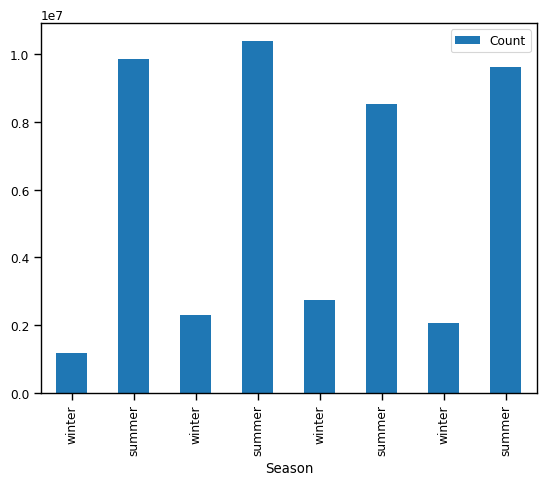

In [48]:
# df_winter = df[df['Month'].isin([11, 12, 1, 2, 3, 4])]
# df_summer = df[df['Month'].isin([5, 6, 7, 8, 9, 10])]
# Use dataset that does not include July 2021

df_winter = df1[df1['Month'].isin(['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])]
df_summer = df1[df1['Month'].isin(['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])]

df_seasons = pd.DataFrame({'Year'  : [2019, 2019, 2020, 2020, 2021, 2021, 2022, 2022],
                          'Season': ['winter', 'summer', 'winter', 'summer', 'winter', 'summer', 'winter', 'summer'],
                          'Count' : [df_winter[df_winter['Year'] == 2019]['Sum'].sum(),
                                     df_summer[df_summer['Year'] == 2019]['Sum'].sum(),
                                     df_winter[df_winter['Year'] == 2020]['Sum'].sum(),
                                     df_summer[df_summer['Year'] == 2020]['Sum'].sum(),
                                     df_winter[df_winter['Year'] == 2021]['Sum'].sum(),
                                     df_summer[df_summer['Year'] == 2021]['Sum'].sum(),
                                     df_winter[df_winter['Year'] == 2022]['Sum'].sum(),
                                     df_summer[df_summer['Year'] == 2022]['Sum'].sum()
                                    ]})
print(df_seasons)
df_seasons.plot.bar(x='Season', y='Count')

In [49]:
winter_median = df_seasons[df_seasons['Season']=='winter']['Count'].median()
winter_mean   = df_seasons[df_seasons['Season']=='winter']['Count'].mean()
winter_std    = df_seasons[df_seasons['Season']=='winter']['Count'].std()

summer_median = df_seasons[df_seasons['Season']=='summer']['Count'].median()
summer_mean   = df_seasons[df_seasons['Season']=='summer']['Count'].mean()
summer_std    = df_seasons[df_seasons['Season']=='summer']['Count'].std()

df_seasons_stats = pd.DataFrame([{'Season': 'winter', 'median': winter_median, 'mean': winter_mean, 'std': winter_std},
                                 {'Season': 'summer', 'median': summer_median, 'mean': summer_mean, 'std': summer_std}])
df_seasons_stats

,Season,median,mean,std
0,winter,2190418.5,2071848.5,661852.888884
1,summer,9740020.0,9601904.5,783600.502574


In [50]:
fig3 = px.box(df_seasons, x="Season", y="Count", points="all", 
              color="Season",
              width=500,height=400,
              title="Bike Counts in winter vs. summer for 2019-2023", 
              template='ggplot2')
fig3.update_layout(yaxis_title="Totals (44 bike counters)")
fig3.add_annotation(text=f"Median={df_seasons_stats['median'][0]}", x="winter", y=4000000, showarrow=False)
fig3.add_annotation(text=f"Median={df_seasons_stats['median'][1]}", x="summer", y=7000000, showarrow=False)
fig3.show()
fig3.write_image('fig-boxplot_bikes_by_seasons_2019-2023.png')

In [51]:
# Difference between winter and summer

#print(f"Number of recorded passages during winter (November to April, inclusively) represent {int((2302941.0 / 10006528.5) * 100)}% of the counts in summer months (May-Oct).")
perc = ( df_seasons_stats['median'][0] / df_seasons_stats['median'][1] ) * 100
print(f"Number of recorded passages during winter (November to April, inclusively) represent {int(perc)}% of the counts in summer months (May-Oct).")


Number of recorded passages during winter (November to April, inclusively) represent 22% of the counts in summer months (May-Oct).


## Use data from all counters

When using data from all counters, the downward trend 

In [52]:
def reshape(df):
    """
    List columns to re-shape and convert "wide" to "long" format
    """
    cols = df.columns.tolist()
    cols.remove('Date')
    
    df = df.reset_index()
    df_long = pd.melt(df, id_vars='Date', value_vars=cols)

    df_long['Date'] = pd.to_datetime(df_long['Date'], errors='coerce')
    return(df_long)

In [53]:
# Re-shape counters tables from wide to long

df_counts_2019 = reshape(df_2019)
df_counts_2020 = reshape(df_2020)
df_counts_2021 = reshape(df_2021)
df_counts_2022 = reshape(df_2022)

# Summarize counts for each month, for every year

df_all_2019 = sum_by_month(df_counts_2019, 2019)
df_all_2020 = sum_by_month(df_counts_2020, 2020)
df_all_2021 = sum_by_month(df_counts_2021, 2021)
df_all_2022 = sum_by_month(df_counts_2022, 2022)

# 2023 is already in long format, and only contains data for January

sum_2023_01 = df_2023['nb_passages'].sum()
df_all_2023 = pd.DataFrame({'Year' : ['2023'], 
                            'Month': [1],
                            'Sum'  : [sum_2023_01]})

# Concatenate sum of counts for every year together

df = pd.concat([df_all_2019, df_all_2020, df_all_2021, df_all_2022, df_all_2023], axis=0)
df_seasons_stats['median']


0    2190418.5
1    9740020.0
Name: median, dtype: float64

In [54]:
# Convert counts to int and replace Month labels

df0 = df
df0 = df0.reset_index(drop=True)
df0['Sum'] = df0['Sum'].astype(int)
df0.loc[df0['Month'] == 1,  'Month'] = 'Jan'
df0.loc[df0['Month'] == 2,  'Month'] = 'Feb'
df0.loc[df0['Month'] == 3,  'Month'] = 'Mar'
df0.loc[df0['Month'] == 4,  'Month'] = 'Apr'
df0.loc[df0['Month'] == 5,  'Month'] = 'May'
df0.loc[df0['Month'] == 6,  'Month'] = 'Jun'
df0.loc[df0['Month'] == 7,  'Month'] = 'Jul'
df0.loc[df0['Month'] == 8,  'Month'] = 'Aug'
df0.loc[df0['Month'] == 9,  'Month'] = 'Sep'
df0.loc[df0['Month'] == 10, 'Month'] = 'Oct'
df0.loc[df0['Month'] == 11, 'Month'] = 'Nov'
df0.loc[df0['Month'] == 12, 'Month'] = 'Dec'
#print(df0)
#df0.plot.bar(x='Month', y='Sum')

In [55]:
fig1 = px.bar(df0, x=df0.index, y='Sum', title="Foo", template='ggplot2')
fig1.update_xaxes(title_text='Months', tickvals=df0.index, ticktext=df0['Month'].tolist())
fig1.show()

When using data from all counters, the decrease in the number of passages in later years is not observed. Acttually, we see the opposite.

### July 2019 outlier

July 2019 is an outlier, with about twice as many passages counted. Is this caused by a single counter, which has been removed? This outlier is not found when taking counts only for counters common to 2019-2023.

Further investigation (see Supplementary analyses) indicates that "compteur_39" has over 45% more counts than the second highest counter. It may have gone trigger-happy, but this counter is not amongst the counters that are common to all years from 2019 to 2023.

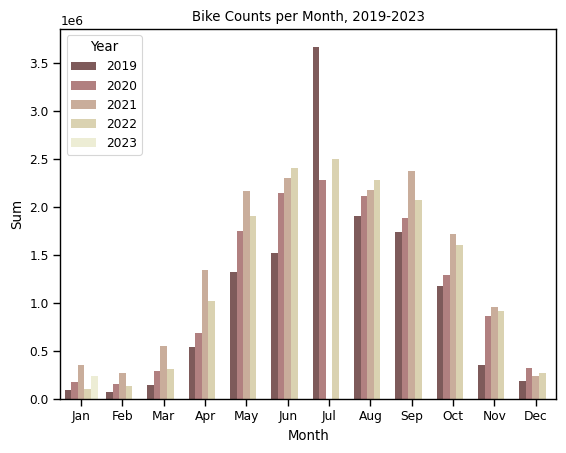

In [56]:
sns.set_context('paper')
sns.barplot(x='Month', y='Sum', hue='Year', data=df0, palette='pink')
plt.title('Bike Counts per Month, 2019-2023')
plt.show()

## References

- https://donnees.montreal.ca/ville-de-montreal/velos-comptage

## Supplementary analyses

### July 2021

In [57]:
# Supplementary analyses
# July 2021 has no counts! What went wrong?

df_2021_07 = df_2021_counts[df_2021_counts['Date'].dt.month == 7]
print(df_2021_07)

# The problem is not in the filtering of counts

df_2021_07 = df_2021_counts[(df_2021_counts['Date'] >= '2021-07-01') & (df_2021_counts['Date'] < '2021-08-01')]
print(df_2021_07)

# In fact, there is no data for July 2021: `grep '2021-07' comptage_velo_2021.csv` yields no match
# There are data for June 30th and August 1st, but nothing for July

df_2021[(df_2021['Date'] >= '2021-06-30') & (df_2021['Date'] <= '2021-08-01')]

Empty DataFrame
Columns: [Date, variable, value]
Index: []
Empty DataFrame
Columns: [Date, variable, value]
Index: []


,Date,compteur_100054073,compteur_100003040,compteur_100052606,compteur_100003032,compteur_100053057,compteur_100053058,compteur_100012218,compteur_100035408,compteur_100004575,...,compteur_300014996,compteur_100011747,compteur_100025474,compteur_100017523,compteur_100053055,compteur_100053210,compteur_100017441,compteur_100053059,compteur_100047030,compteur_100057052
17280,2021-06-30 00:00:00,1.0,1.0,0.0,16.0,NaN,0.0,4.0,8.0,0.0,...,6.0,0.0,22.0,4.0,1.0,0.0,8.0,1.0,0.0,NaN
17281,2021-06-30 00:15:00,0.0,2.0,0.0,8.0,NaN,0.0,7.0,9.0,0.0,...,12.0,0.0,27.0,2.0,1.0,3.0,10.0,0.0,0.0,NaN
17282,2021-06-30 00:30:00,1.0,1.0,0.0,9.0,NaN,0.0,5.0,1.0,0.0,...,2.0,0.0,12.0,1.0,1.0,2.0,3.0,2.0,2.0,NaN
17283,2021-06-30 00:45:00,0.0,2.0,3.0,8.0,NaN,0.0,4.0,5.0,0.0,...,6.0,0.0,16.0,0.0,0.0,1.0,1.0,2.0,1.0,NaN
17284,2021-06-30 01:00:00,0.0,0.0,1.0,12.0,NaN,0.0,3.0,1.0,0.0,...,4.0,0.0,13.0,1.0,0.0,0.0,0.0,2.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17371,2021-06-30 22:45:00,1.0,0.0,2.0,13.0,NaN,0.0,13.0,4.0,0.0,...,11.0,0.0,36.0,4.0,3.0,2.0,5.0,0.0,3.0,NaN
17372,2021-06-30 23:00:00,4.0,0.0,1.0,28.0,NaN,0.0,17.0,25.0,0.0,...,17.0,0.0,32.0,3.0,1.0,2.0,12.0,4.0,1.0,NaN
17373,2021-06-30 23:15:00,1.0,3.0,2.0,24.0,NaN,0.0,19.0,13.0,0.0,...,22.0,0.0,46.0,8.0,3.0,3.0,8.0,2.0,3.0,NaN
17374,2021-06-30 23:30:00,0.0,2.0,4.0,29.0,NaN,0.0,11.0,20.0,0.0,...,25.0,0.0,37.0,3.0,1.0,1.0,10.0,0.0,0.0,NaN


In [64]:
# Looking for the outlier in July 2019

df_2019_outlier = df_2019
df_2019_outlier['Date'] = pd.to_datetime(df_2019_outlier['Date'])
df_2019_07 = df_2019_outlier[df_2019_outlier['Date'].dt.month == 7]

# Drop column 'Date' before summing up counts for each remaining column (counters)
df_2019_07 = df_2019_07.drop(columns=['Date'])
sums_2019_07 = df_2019_07.sum(axis=0)
sums_2019_07 = sums_2019_07.sort_values(ascending=False)
print(sums_2019_07.head())

df_sums = pd.DataFrame({'compteur': sums_2019_07.index, 'sum_07': sums_2019_07.values})
fig_2019_07 = px.box(df_sums, y="sum_07", width=400, points="all")
fig_2019_07.show()

# "compteur_39" seems to be the outlier
# Is this counter in the list of counters common to all years?

if 'compteur_39' in set(counters):
    print("'compteur_39' is in the list of common counters")
else:
    print("'compteur_39' is NOT in the list of common counters")


compteur_39           490390.0
compteur_100003039    337124.0
compteur_100007390    314724.0
compteur_100012218    234008.0
compteur_100053210    223594.0
dtype: float64


'compteur_39' is NOT in the list of common counters


In [59]:
dill.dump_session('velo-counter.dill.db')

NameError: name 'dill' is not defined